In [13]:
import pandas as pd
import plotly.express as px
import numpy as np

In [48]:
df=pd.read_excel(r'C:\Users\p048168\Downloads\Datos_TF.xlsx',
                sheet_name='Brasil')
names=df.columns[1:]
df.head()

,date,TOT,TB,GDP,C,I,RER
0,1980,0.239544,-0.028833,0.193278,0.236764,0.307172,-0.162246
1,1981,0.026023,-0.006117,0.099178,0.120134,0.203791,-0.194108
2,1982,-0.047607,-0.009385,0.056955,0.103740,0.073756,-0.170767
3,1983,-0.116481,0.020806,-0.024340,0.049106,-0.239491,0.177551
4,1984,-0.075313,0.052102,-0.017890,0.045868,-0.288104,0.315800


In [108]:
px.line(df,x='date',y=names)

In [109]:
from statsmodels.tsa.api import VAR

In [85]:
variables_1=['GDP','TB','C','I','RER']

In [87]:
## elegir el numero de rezagos

container=[]
for rezagos in range(1,5):
    model = VAR(df[variables_1])
    results = model.fit(rezagos)
    container.append([
        rezagos,
        results.aic,
        results.bic,
        results.hqic,
        not any([False if np.linalg.norm(raiz)>1 
              else True 
              for  raiz in results.roots])
    ])

df_resultados=pd.DataFrame(container,columns=['Rezagos','AIC','BIC','HQIC','Estacionario'])
df_resultados.head()

,Rezagos,AIC,BIC,HQIC,Estacionario
0,1,-32.613040,-31.225310,-32.160675,True
1,2,-32.332407,-29.763545,-31.510606,True
2,3,-34.028472,-30.256622,-32.847176,False
3,4,-37.196631,-32.200864,-35.669375,False


In [120]:
model = VAR(df[variables_1])
results = model.fit(2)

In [121]:
##normalidad de los errores
from statsmodels.stats.stattools import jarque_bera  

container=[]
for variable in variables_1:
    container.append([variable,jarque_bera(results.resid[variable])[1]])
df_test_norm=pd.DataFrame(container,columns=['Variable','Jarque Bera p-value'])
df_test_norm
#no se rechaza la nula de normalidad, hay evidencia de que los residuos son normales 

,Variable,Jarque Bera p-value
0,GDP,0.752341
1,TB,0.868700
2,C,0.689601
3,I,0.891677
4,RER,0.586326


In [123]:
import itertools as it

lista_test=list(it.permutations(variables_1,2))

In [124]:
## test de causalidad
for par_test in lista_test:
    print(results.test_causality(*par_test).summary())

Granger causality F-test. H_0: TB does not Granger-cause GDP. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.8617          3.092   0.426 (2, 95)
---------------------------------------------
Granger causality F-test. H_0: C does not Granger-cause GDP. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.8878          3.092   0.415 (2, 95)
---------------------------------------------
Granger causality F-test. H_0: I does not Granger-cause GDP. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.1300          3.092   0.878 (2, 95)
---------------------------------------------
Granger causality F-test. H_0: RER does not Granger-cause GDP. Conclusion: fail to reject H_0

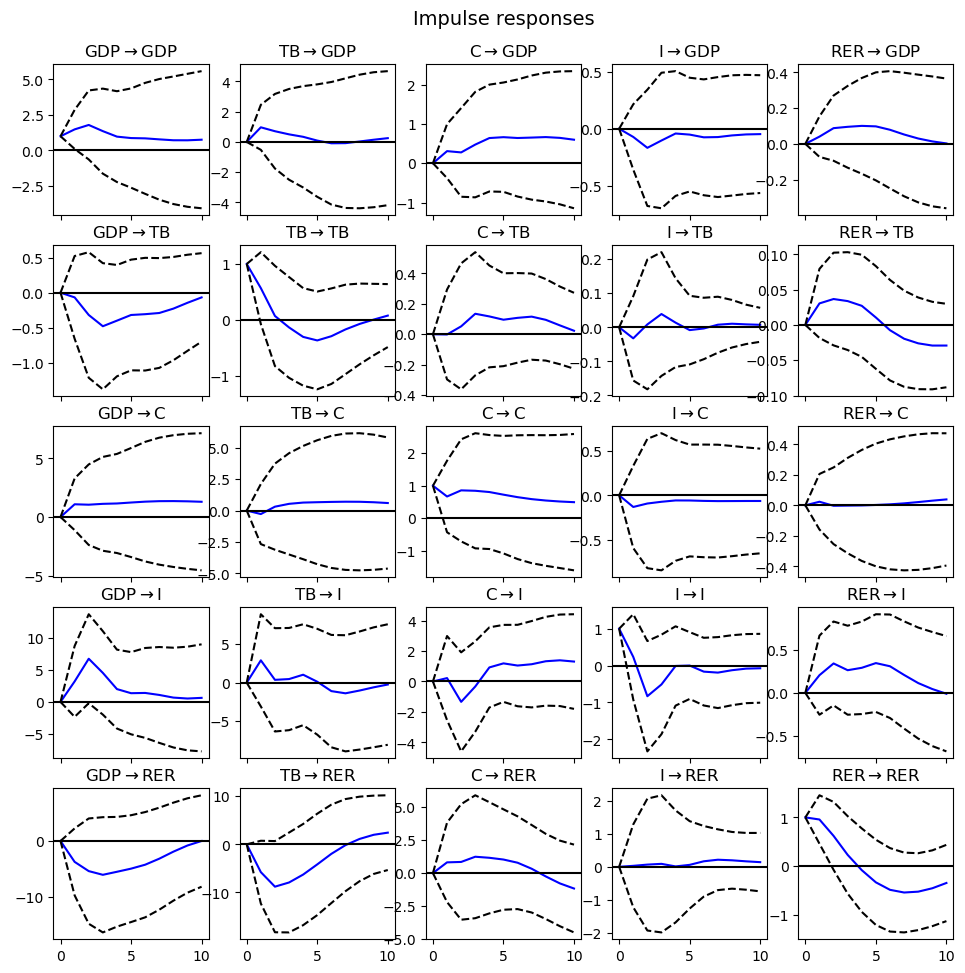

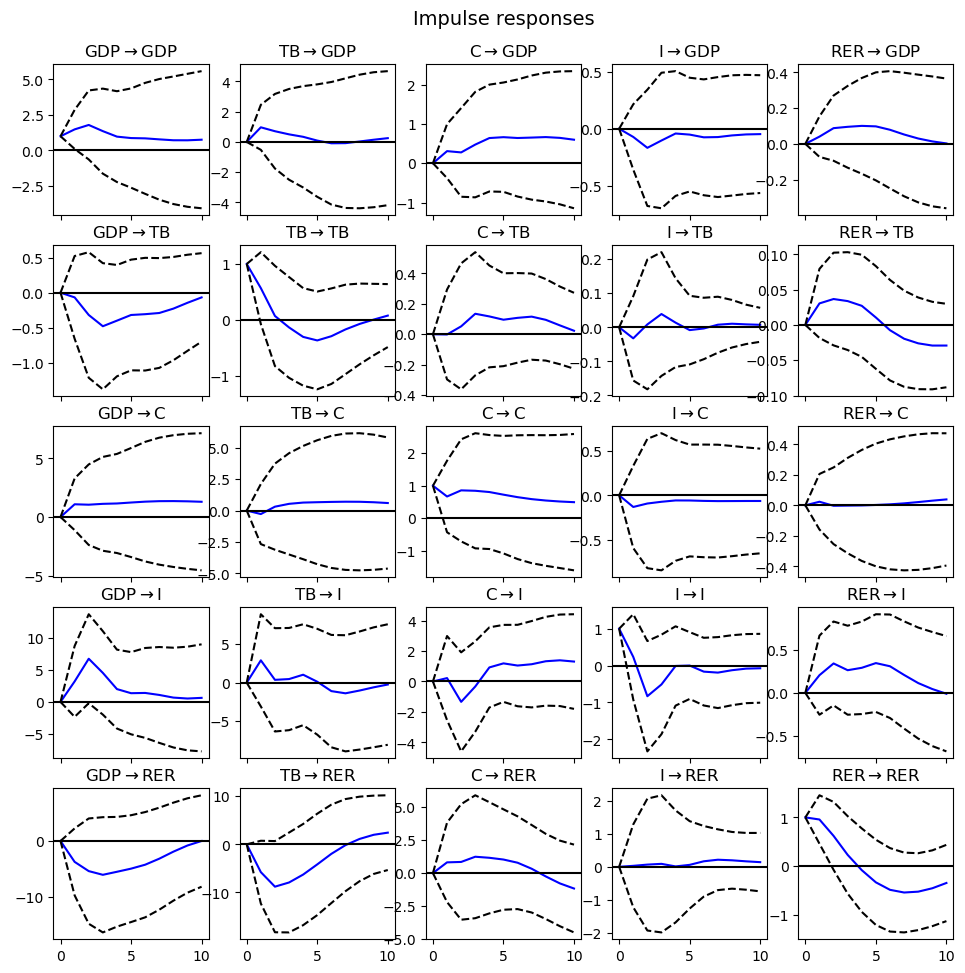

In [160]:
### funciones de impulso respuesta
impulso_respuesta=results.irf(10)

impulso_respuesta.plot()

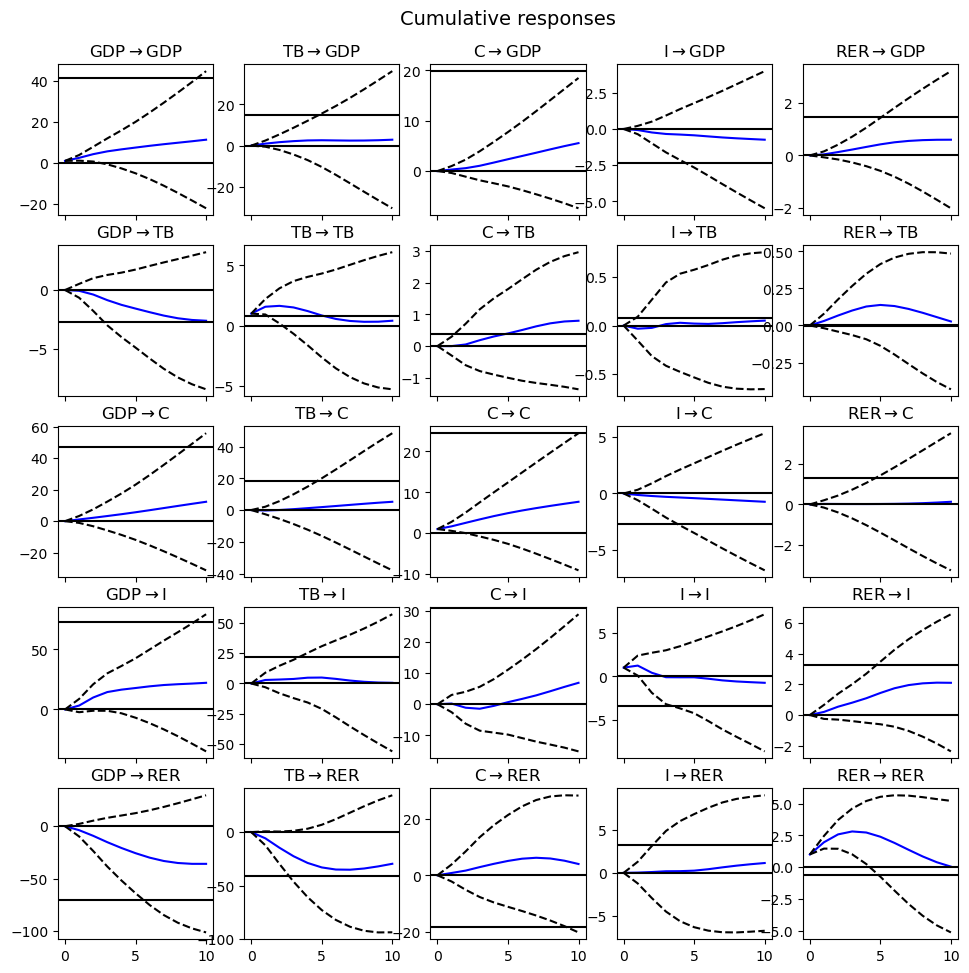

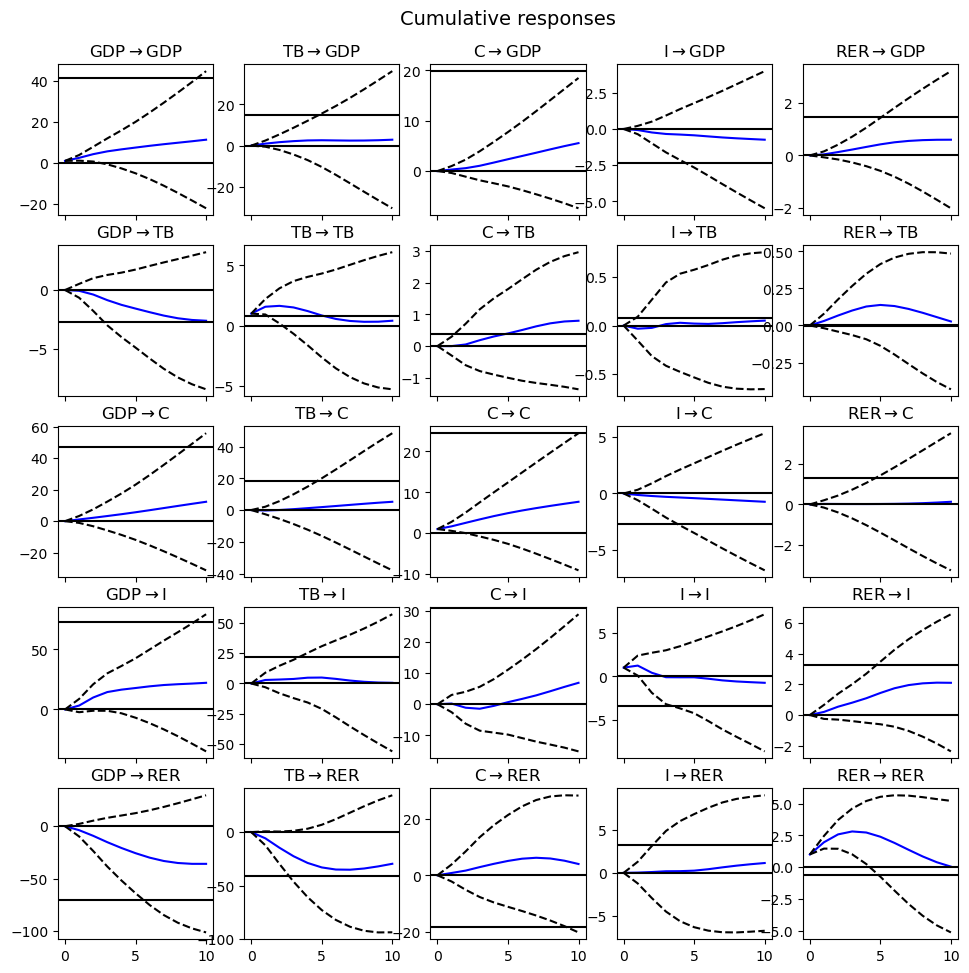

In [161]:
## irf acumuladas (por si alguna variable esta en diferencias)

impulso_respuesta.plot_cum_effects()

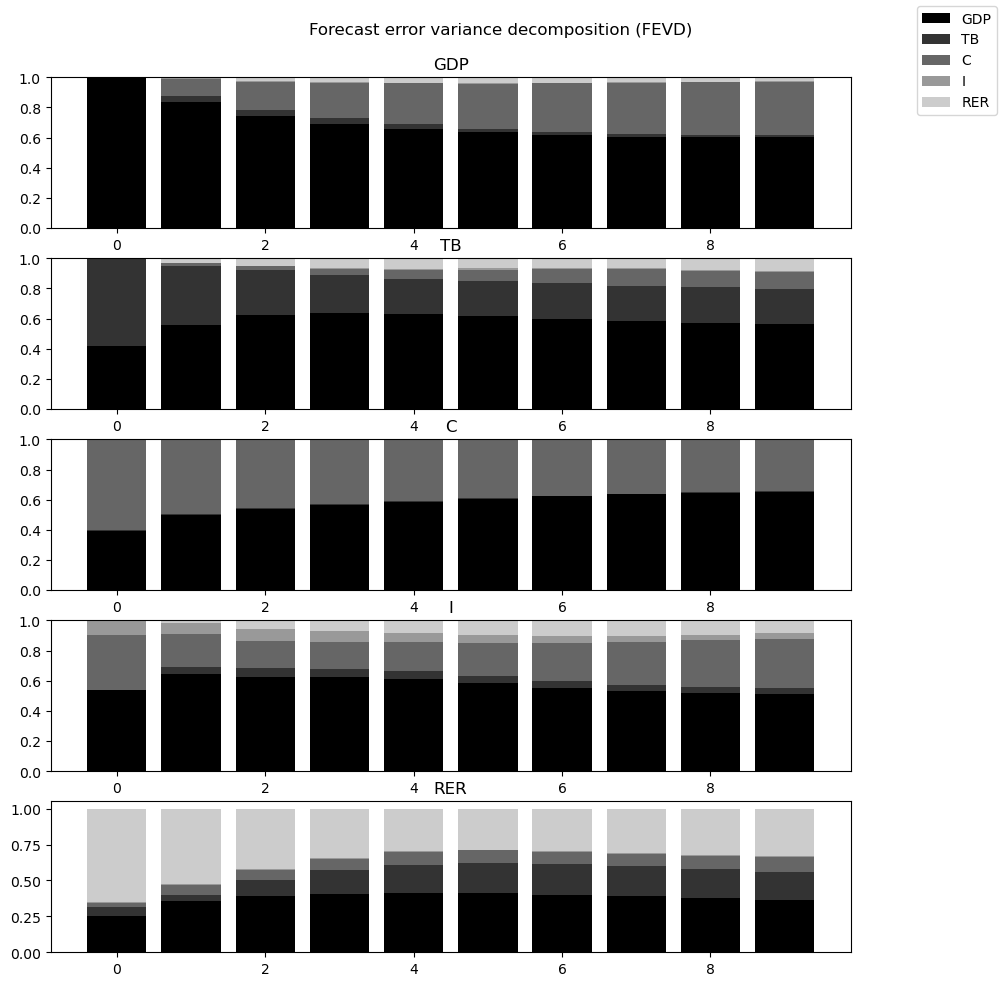

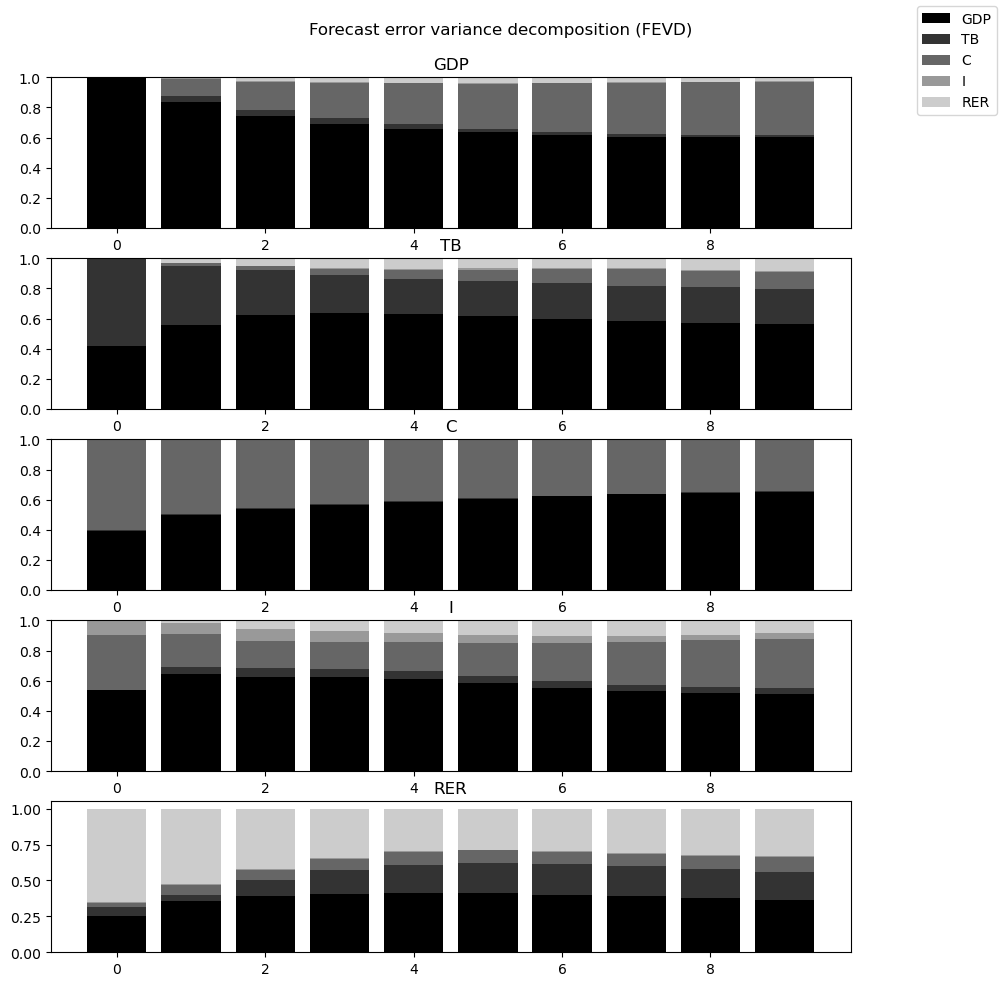

In [164]:
### descomposicion de errores
##grafico
results.fevd(10).plot()

In [165]:
### tabla
results.fevd(10).summary()

FEVD for GDP
          GDP        TB         C         I       RER
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.838624  0.037778  0.114756  0.001928  0.006913
2    0.740064  0.041749  0.188688  0.007181  0.022318
3    0.691431  0.035364  0.236823  0.006101  0.030282
4    0.659767  0.028693  0.271441  0.004632  0.035467
5    0.634701  0.023296  0.300163  0.003782  0.038058
6    0.616824  0.019558  0.323047  0.003454  0.037116
7    0.606203  0.017008  0.339455  0.003287  0.034047
8    0.601529  0.015094  0.349625  0.003105  0.030648
9    0.601373  0.013595  0.354394  0.002948  0.027690

FEVD for TB
          GDP        TB         C         I       RER
0    0.419252  0.580748  0.000000  0.000000  0.000000
1    0.559185  0.387471  0.023018  0.002079  0.028247
2    0.627080  0.293035  0.025848  0.002673  0.051364
3    0.640050  0.250087  0.036287  0.008262  0.065315
4    0.632555  0.232861  0.055725  0.008396  0.070464
5    0.616364  0.231657  0.077779  0.007761  0.066440
6 

In [174]:
## para la pregunta 2, usando una exogena

model2 = VAR(endog=df[variables_1],exog=df['TOT'])
results2 = model2.fit(2)

In [175]:
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Jun, 2024
Time:                     02:25:14
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -29.7491
Nobs:                     30.0000    HQIC:                  -31.6550
Log likelihood:           335.431    FPE:                9.24226e-15
AIC:                     -32.5515    Det(Omega_mle):     1.71845e-15
--------------------------------------------------------------------
Results for equation GDP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002978         0.005872            0.507           0.612
TOT            0.152248         0.072412            2.103           0.036
L1.GDP         1.422089         0.645690            2.202           0.028
L1.TB          0